# Installs

In [1]:
!pip install 'monai[einops]' --no-index --find-links=../input/hubmap-library-download/

Looking in links: ../input/hubmap-library-download/
Processing /kaggle/input/hubmap-library-download/monai-0.9.0-202206131636-py3-none-any.whl
Processing /kaggle/input/hubmap-library-download/einops-0.4.1-py3-none-any.whl


# Imports

In [2]:
from pathlib import Path
from typing import Any
from typing import Callable
from typing import Dict
from typing import Optional
from typing import Tuple

import monai
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import tifffile
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from monai.data import CSVDataset
from monai.data import DataLoader
from monai.data import ImageReader
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

# Paths & Settings

In [3]:
KAGGLE_DIR = Path("/") / "kaggle"

INPUT_DIR = KAGGLE_DIR / "input"
OUTPUT_DIR = KAGGLE_DIR / "working"

COMPETITION_DATA_DIR = INPUT_DIR / "hubmap-organ-segmentation"

TRAIN_PREPARED_CSV_PATH = "train_prepared.csv"
VAL_PRED_PREPARED_CSV_PATH = "val_pred_prepared.csv"
TEST_PREPARED_CSV_PATH = "test_prepared.csv"

N_SPLITS = 4
RANDOM_SEED = 2022
SPATIAL_SIZE = 1024
VAL_FOLD = 0
NUM_WORKERS = 2
BATCH_SIZE = 16
MODEL = "unet"
LOSS = "dice"
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.0
FAST_DEV_RUN = False
GPUS = 1
MAX_EPOCHS = 10
PRECISION = 16
DEBUG = False

DEVICE = "cuda"
THRESHOLD = 0.5

# Prepare DataFrames (Add paths and create folds)

In [4]:
def add_path_to_df(df: pd.DataFrame, data_dir: Path, type_: str, stage: str) -> pd.DataFrame:
    ending = ".tiff" if type_ == "image" else ".npy"
    
    dir_ = str(data_dir / f"{stage}_{type_}s") if type_ == "image" else f"{stage}_{type_}s"
    df[type_] = dir_ + "/" + df["id"].astype(str) + ending
    return df


def add_paths_to_df(df: pd.DataFrame, data_dir: Path, stage: str) -> pd.DataFrame:
    df = add_path_to_df(df, data_dir, "image", stage)
    df = add_path_to_df(df, data_dir, "mask", stage)
    return df


def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = fold

    return df


def prepare_data(data_dir: Path, stage: str, n_splits: int, random_seed: int) -> None:
    df = pd.read_csv(data_dir / f"{stage}.csv")
    df = add_paths_to_df(df, data_dir, stage)

    if stage == "train":
        df = create_folds(df, n_splits, random_seed)

    filename = f"{stage}_prepared.csv"
    df.to_csv(filename, index=False)

    print(f"Created {filename} with shape {df.shape}")

    return df

In [5]:
train_df = prepare_data(COMPETITION_DATA_DIR, "train", N_SPLITS, RANDOM_SEED)
test_df = prepare_data(COMPETITION_DATA_DIR, "test", N_SPLITS, RANDOM_SEED)

Created train_prepared.csv with shape (351, 13)
Created test_prepared.csv with shape (1, 9)


In [6]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image,mask,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10044.npy,3.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10274.npy,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10392.npy,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10488.npy,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/10610.npy,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9517.npy,2.0
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9769.npy,0.0
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9777.npy,2.0
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,train_masks/9791.npy,0.0


In [7]:
test_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,image,mask
0,10078,spleen,Hubmap,2023,2023,0.4945,4,/kaggle/input/hubmap-organ-segmentation/test_i...,test_masks/10078.npy


# Save Train Masks as NumPy Arrays

In [8]:
def rle2mask(mask_rle: str, shape: Tuple[int, int]) -> np.ndarray:
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def save_array(file_path: str, array: np.ndarray) -> None:
    file_path = Path(file_path)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(file_path, array)


def save_masks(df: pd.DataFrame) -> None:
    for row in tqdm(df.itertuples(), total=len(df)):
        mask = rle2mask(row.rle, shape=(row.img_width, row.img_height))
        save_array(row.mask, mask)

In [9]:
save_masks(train_df)

  0%|          | 0/351 [00:00<?, ?it/s]

# Lightning DataModule

In [10]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

class TIFFImageReader(ImageReader):
    def read(self, data: str) -> np.ndarray:
        image = tifffile.imread(data)
        image = rgb2gray(image)
        return image

    def get_data(self, img: np.ndarray) -> Tuple[np.ndarray, Dict[str, Any]]:
        return img, {"spatial_shape": np.asarray(img.shape), "original_channel_dim": -1}

    def verify_suffix(self, filename: str) -> bool:
        return ".tiff" in filename

In [11]:
class LitDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_csv_path: str,
        test_csv_path: str,
        spatial_size: int,
        val_fold: int,
        batch_size: int,
        num_workers: int,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.train_df = pd.read_csv(train_csv_path)
        self.test_df = pd.read_csv(test_csv_path)

        self.train_transform, self.val_transform, self.test_transform = self._init_transforms()
        
    def _init_transforms(self) -> Tuple[Callable, Callable, Callable]:
        spatial_size = (self.hparams.spatial_size, self.hparams.spatial_size)
        train_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader),
                monai.transforms.AddChanneld(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.LoadImaged(keys=["mask"]),
                monai.transforms.AddChanneld(keys=["mask"]),
                monai.transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
                monai.transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
                monai.transforms.RandRotate90d(keys=["image", "mask"], prob=0.75, spatial_axes=(0, 1)),
                monai.transforms.OneOf(
                    [
                        #monai.transforms.RandGaussianNoised(keys=["image"], prob=1.0, std=0.1),
                        monai.transforms.RandAdjustContrastd(keys=["image"], prob=1.0, gamma=(0.5, 4.5)),
                        monai.transforms.RandShiftIntensityd(keys=["image"], prob=1.0, offsets=(0.1, 0.2)),
                        monai.transforms.RandHistogramShiftd(keys=["image"], prob=1.0),
                    ]
                ),
                monai.transforms.OneOf(
                    [
                        monai.transforms.RandGridDistortiond(keys=["image", "mask"], prob=0.5, distort_limit=0.2),
                        #monai.transforms.RandZoomd(keys=["image", "mask"], prob=0.5, spatial_size=spatial_size,  mode="nearest"),

                    ]
                ),
                monai.transforms.Resized(keys=["image", "mask"], spatial_size=spatial_size, mode="nearest"),
                monai.transforms.ToTensord(keys=["image", "mask"]),
            ]
        )

        val_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader),
                monai.transforms.AddChanneld(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.LoadImaged(keys=["mask"]),
                monai.transforms.AddChanneld(keys=["mask"]),
                #monai.transforms.RandZoomd(keys=["image", "mask"], prob=0.5, spatial_size=spatial_size,  mode="nearest"),
                monai.transforms.Resized(keys=["image", "mask"], spatial_size=spatial_size, mode="nearest"),
                monai.transforms.ToTensord(keys=["image", "mask"]),
            ]
        )

        test_transform = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"], reader=TIFFImageReader),
                monai.transforms.AddChanneld(keys=["image"]),
                monai.transforms.ScaleIntensityd(keys=["image"]),
                monai.transforms.Resized(keys=["image"], spatial_size=spatial_size, mode="nearest"),
                monai.transforms.ToTensord(keys=["image"]),
            ]
        )

        return train_transform, val_transform, test_transform

    def setup(self, stage: str = None):
        if stage == "fit" or stage is None:
            train_df = self.train_df[self.train_df.fold != self.hparams.val_fold].reset_index(drop=True)
            val_df = self.train_df[self.train_df.fold == self.hparams.val_fold].reset_index(drop=True)

            self.train_dataset = self._dataset(train_df, transform=self.train_transform)
            self.val_dataset = self._dataset(val_df, transform=self.val_transform)

        if stage == "test" or stage is None:
            self.test_dataset = self._dataset(self.test_df, transform=self.test_transform)

    def _dataset(self, df: pd.DataFrame, transform: Callable) -> CSVDataset:
        return CSVDataset(src=df, transform=transform)

    def train_dataloader(self) -> DataLoader:
        return self._dataloader(self.train_dataset, train=True)

    def val_dataloader(self) -> DataLoader:
        return self._dataloader(self.val_dataset)

    def test_dataloader(self) -> DataLoader:
        return self._dataloader(self.test_dataset)

    def _dataloader(self, dataset: CSVDataset, train: bool = False) -> DataLoader:
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
        )

# Visualize Images and Masks

In [12]:
def show_image(title: str, image: np.ndarray, mask: Optional[np.ndarray] = None):
    plt.title(title)
    plt.imshow(image)

    if mask is not None:
        plt.imshow(mask, alpha=0.2)

    plt.tight_layout()
    plt.axis("off")


def show_batch(batch: Dict, nrows: int, show_mask: bool = True):
    fig, _ = plt.subplots(figsize=(3 * nrows, 3 * nrows))

    for idx, _ in enumerate(batch["image"]):
        plt.subplot(nrows, nrows, idx + 1)

        title = batch["id"][idx].numpy()
        image = np.transpose(batch["image"][idx].numpy(), axes=(1, 2, 0))
        mask = np.transpose(batch["mask"][idx].numpy(), axes=(1, 2, 0)) if show_mask else None

        show_image(title, image, mask)

## Setup DataModule

In [13]:
nrows = 1

data_module = LitDataModule(
    train_csv_path=TRAIN_PREPARED_CSV_PATH,
    test_csv_path=TEST_PREPARED_CSV_PATH,
    spatial_size=SPATIAL_SIZE,
    val_fold=VAL_FOLD,
    batch_size=nrows ** 2,
    num_workers=NUM_WORKERS,
)
data_module.setup()

## Train Images

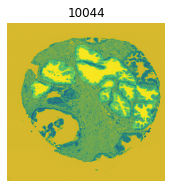

In [14]:
train_batch = next(iter(data_module.train_dataloader()))
show_batch(train_batch, nrows)

## Test Images

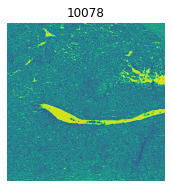

In [15]:
test_batch = next(iter(data_module.test_dataloader()))
show_batch(test_batch, nrows, show_mask=False)

# Lightning Module

In [16]:
class LitModule(pl.LightningModule):
    def __init__(
        self,
        model: str,
        loss: str,
        spatial_size: int,
        learning_rate: float,
        weight_decay: float,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model()

        self.loss_fn = self._init_loss_fn()

        # TODO: add metric

    def _init_model(self) -> nn.Module:
        spatial_size = (self.hparams.spatial_size, self.hparams.spatial_size)
        
        if self.hparams.model == "unet":
            return monai.networks.nets.UNet(
                spatial_dims=2,
                in_channels=1,
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
            )
        elif self.hparams.model == "attention_unet":
            return monai.networks.nets.AttentionUnet(
                spatial_dims=2,
                in_channels=3,
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
            )
        elif self.hparams.model == "unetr":
            return monai.networks.nets.UNETR(
                in_channels=3,
                img_size=spatial_size,
                out_channels=1,
                spatial_dims=2,
            )
        elif self.hparams.model == "swin_unetr":
            return monai.networks.nets.SwinUNETR(
                img_size=spatial_size,
                in_channels=3,
                out_channels=1,
                spatial_dims=2,
            )

    def _init_loss_fn(self):
        if self.hparams.loss == "dice":
            return monai.losses.DiceLoss(sigmoid=True)
        elif self.hparams.loss == "bce":
            return nn.BCEWithLogitsLoss()

    def configure_optimizers(self):
        # TODO: try other optimizers and schedulers
        return torch.optim.Adam(
            params=self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        return self.model(images)

    def training_step(self, batch: Dict, batch_idx: int) -> torch.Tensor:
        images, masks = batch["image"], batch["mask"]
        outputs = self(images)

        loss = self.loss_fn(outputs, masks)

        self.log("train_loss", loss, batch_size=images.shape[0])

        return loss

    def validation_step(self, batch: Dict, batch_idx: int) -> None:
        images, masks = batch["image"], batch["mask"]
        outputs = self(images)

        loss = self.loss_fn(outputs, masks)

        self.log("val_loss", loss, prog_bar=True, batch_size=images.shape[0])

    @classmethod
    def load_eval_checkpoint(cls, checkpoint_path: str, device: str) -> nn.Module:
        module = cls.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
        module.eval()

        return module

# Train

In [17]:
def train(
    random_seed: int = RANDOM_SEED,
    train_csv_path: str = str(TRAIN_PREPARED_CSV_PATH),
    test_csv_path: str = str(TEST_PREPARED_CSV_PATH),
    spatial_size: Tuple[int, int] = SPATIAL_SIZE,
    val_fold: str = VAL_FOLD,
    batch_size: int = BATCH_SIZE,
    num_workers: int = NUM_WORKERS,
    model: str = MODEL,
    loss: str = LOSS,
    learning_rate: float = LEARNING_RATE,
    weight_decay: float = WEIGHT_DECAY,
    fast_dev_run: bool = FAST_DEV_RUN,
    gpus: int = GPUS,
    max_epochs: int = MAX_EPOCHS,
    precision: int = PRECISION,
    debug: bool = DEBUG,
) -> None:
    pl.seed_everything(random_seed)

    data_module = LitDataModule(
        train_csv_path=train_csv_path,
        test_csv_path=test_csv_path,
        spatial_size=spatial_size,
        val_fold=val_fold,
        batch_size=2 if debug else batch_size,
        num_workers=num_workers,
    )

    module = LitModule(
        model=model,
        loss=loss,
        spatial_size=spatial_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
    )

    trainer = pl.Trainer(
        fast_dev_run=fast_dev_run,
        gpus=gpus,
        limit_train_batches=0.1 if debug else 1.0,
        limit_val_batches=0.1 if debug else 1.0,
        log_every_n_steps=5,
        logger=pl.loggers.CSVLogger(save_dir='logs/'),
        max_epochs=2 if debug else max_epochs,
        precision=precision,
    )

    trainer.fit(module, datamodule=data_module)
    
    return trainer

In [18]:
trainer = train()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

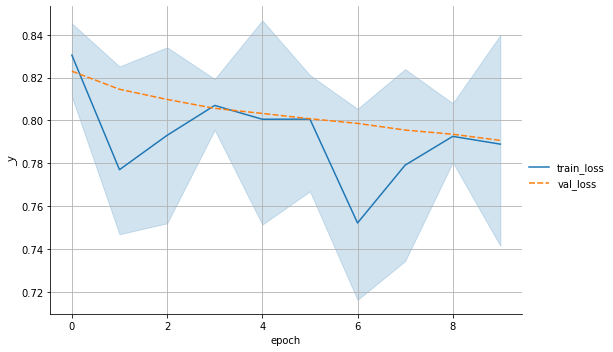

In [19]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")[["epoch", "train_loss", "val_loss"]]
metrics.set_index("epoch", inplace=True)

sns.relplot(data=metrics, kind="line", height=5, aspect=1.5)
plt.grid()